<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">TFM - Previsión de demanda mediante uso de técnicas de machine learning
</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Carlos Pérez Cebrián</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# Impacto económico

Se quiere estudiar el impacto económico que supone la aplicación del modelo que mejor resultados ha obtenido en la predicción de ventas.
Para ello, utilizaremos el modelo XGBoost (Extreme Gradient Boosting) y el conjunto de datos Ventas y Precio Medio

Cargamos las siguientes librerías necesarias:

In [1]:
import random

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import cluster        # algoritmos de clustering.
from sklearn import datasets       
from sklearn.preprocessing import StandardScaler #estandarizar datos
from sklearn.decomposition import PCA #análisis de componentes principales, reducir dimensiones
from sklearn.preprocessing import LabelEncoder #codificación variables categóricas
from sklearn.model_selection import train_test_split  #split dataframes train, test, validación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score #metricas
import xgboost as xgb
from xgboost import XGBRegressor   # Importar la clase XGBClassifier
import math

%matplotlib inline

In [2]:
# Cargar el modelo XGBoost desde el archivo JSON
modelo_xgb = xgb.Booster()
modelo_xgb.load_model('modelo_xgboost.json')

# características del modelo
variables_modelo = modelo_xgb.feature_names
print("Variables utilizadas en el modelo:", variables_modelo)

Variables utilizadas en el modelo: ['producto', 'bolOpen', 'EnPromocion', 'diasemana', 'semana', 'media_7_dias', 'media_30_dias', 'venta_lag_1', 'venta_lag_7', 'venta_lag_30']


Cargar el conjunto de datos:
(Nota: el conjunto de datos es el resultado de una fase de exploración, analisis y preparación previa.

In [3]:
# Cargar el archivo CSV con los datos de ventas
file_path = "Data/VentasRdo.csv"
#file_path = "Data/VentasRdo_10productos.csv"
dfVenta = pd.read_csv(file_path, parse_dates=['idSecuencia'])

# Cargar el archivo CSV con los precios medios de cada producto
file_path = "Data/DatosPrecioMedio.xlsx"
dfPrecioMedio = pd.read_excel(file_path)

In [4]:
# mismas variables
dfVenta_prediccion = dfVenta[variables_modelo].copy()  

# Codificar variables categóricas
label_encoder = LabelEncoder()
dfVenta_prediccion['producto'] = label_encoder.fit_transform(dfVenta_prediccion['producto'])
dfVenta_prediccion['bolOpen'] = label_encoder.fit_transform(dfVenta_prediccion['bolOpen'])
dfVenta_prediccion['EnPromocion'] = label_encoder.fit_transform(dfVenta_prediccion['EnPromocion'])
dfVenta_prediccion['diasemana'] = label_encoder.fit_transform(dfVenta_prediccion['diasemana'])
dfVenta_prediccion['semana'] = label_encoder.fit_transform(dfVenta_prediccion['semana'])

# revisar columnas en dfVenta_prediccion y del modelo
dfVenta_prediccion = dfVenta_prediccion[variables_modelo]

#matriz numpy(formato XGBoost)
X_pred = xgb.DMatrix(dfVenta_prediccion)

In [5]:
# predecir
predicciones = modelo_xgb.predict(X_pred)

# añadir las predicciones
# las predicciones están en escala logaritmica por el problema de la heterostacidad.
dfVenta['predicciones_udsVenta'] = np.exp(predicciones)
# las unidades están en escala logaritmica porque hemos cargado el fichero de la preparación
dfVenta['udsVenta_original'] = np.exp(dfVenta['udsVenta'])

In [6]:
# combinar ventas con dfPrecioMedio
dfResultado = dfVenta.merge(dfPrecioMedio, on='producto')

In [7]:
# Calcular el coste con la unidades actuales y estimadas
dfResultado['importe_prediccion'] = dfResultado['predicciones_udsVenta'] * dfResultado['eurPrecioMedio']
dfResultado['importe_actual'] = dfResultado['udsVenta_original'] * dfResultado['eurPrecioMedio']

# diferencia entre los importes
dfResultado['mejora_economica'] = dfResultado['importe_prediccion'] - dfResultado['importe_actual']

mejora_total = dfResultado['mejora_economica'].sum()
print(f"Mejora económica total: {mejora_total}")

Mejora económica total: -7767713.559337854


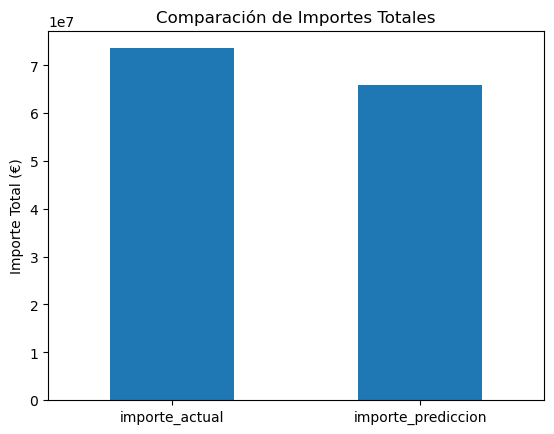

In [8]:
# Graficar los resultados
dfResultado[['importe_actual', 'importe_prediccion']].sum().plot(kind='bar',
                                                                title='Comparación de Importes Totales',
                                                                ylabel='Importe Total (€)',
                                                                rot=0)
plt.show()